
# **Imports & cấu hình chung**

In [3]:
# %% [markdown]
# # IDS Notebook — Pipeline 2-Phase + Save/Plot + Resume
# - Lưu mô hình dạng `.h5` vào D:\DACN\results\training\models
# - Ảnh biểu đồ vào D:\DACN\results\training\plots
# - Bảng so sánh vào D:\DACN\results\training\tables
# - Có thể **tiếp tục train** (resume) mà **không phải chạy lại** tiền xử lý.

import os, glob, io, time, json, warnings, joblib, random, pickle, math
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_fscore_support, accuracy_score
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

warnings.filterwarnings("ignore")

# ==== PATHS (chỉnh theo máy bạn) ====
CIC2019_DIR = r'E:\DACN\dataset\CICDDoS2019'
CIC2017_DIR = r'E:\DACN\dataset\CICDDoS2017'
UNSW15_DIR  = r'E:\DACN\dataset\UNSW_NB15'
NSLKDD_DIR  = r'E:\DACN\dataset\NSL-KDD'   # có KDDTrain+.txt, KDDTest+.txt

# ==== nơi lưu kết quả ====
ROOT_SAVE = Path(r"E:\DACN\results\training")
DIR_MODELS = ROOT_SAVE / "models"
DIR_PLOTS  = ROOT_SAVE / "plots"
DIR_TABLES = ROOT_SAVE / "tables"
for p in [DIR_MODELS, DIR_PLOTS, DIR_TABLES]:
    p.mkdir(parents=True, exist_ok=True)

# ==== loại cột ID/time ====
EXCLUDE_ID_COLUMNS = True
ID_LIKE_COLS = set([
    'Flow ID','FlowID','Timestamp','StartTime','Start Time','stime','time','Date','datetime',
    'Src IP','Dst IP','Source IP','Destination IP',
    'srcip','dstip','srcip_addr','dstip_addr', 
    'Src Port','Dst Port','Sport','Dport','srcport','dstport',
    'ProtocolName','ProtoName','Service','service','state','attack_cat','label',
    'Unnamed: 0','id','No.','Index'
])
LABEL_CANDS = ["Label","label","Attack","attack","attack_cat","class","Class","target","category","Category","result"]

# kiểm soát lệch phân bố từ UNSW (toàn attack)
MAX_UNSW_RATIO = 0.30   # tối đa 30%
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)



# **Giới hạn CPU + TensorFlow threads**

In [4]:
# %%
import multiprocessing as mp

def limit_cpu(fraction: float = 0.90) -> int:
    """
    Giới hạn tài nguyên CPU ~fraction (theo số luồng).
    Trả về số threads cho n_jobs/num_threads.
    """
    fraction = max(0.1, min(1.0, float(fraction)))
    total = os.cpu_count() or mp.cpu_count() or 1
    allow = max(1, math.floor(total * fraction))

    os.environ["OMP_NUM_THREADS"] = str(allow)
    os.environ["OPENBLAS_NUM_THREADS"] = str(allow)
    os.environ["MKL_NUM_THREADS"] = str(allow)
    os.environ["VECLIB_MAXIMUM_THREADS"] = str(allow)
    os.environ["NUMEXPR_MAX_THREADS"] = str(allow)
    os.environ["NUMEXPR_NUM_THREADS"] = str(allow)

    try:
        from threadpoolctl import threadpool_limits
        threadpool_limits(allow)
    except Exception:
        pass

    try:
        import psutil
        p = psutil.Process()
        cpus = list(range(allow))
        p.cpu_affinity(cpus)
    except Exception:
        pass

    print(f"[CPU] total={total} | allow={allow} threads (~{fraction*100:.0f}%)")
    return allow

threads_allowed = limit_cpu(0.90)

import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(threads_allowed)
tf.config.threading.set_inter_op_parallelism_threads(max(1, threads_allowed//2))


[CPU] total=28 | allow=25 threads (~90%)



# **Hàm I/O an toàn + Chuẩn hoá nhãn**

In [5]:
def safe_read_any(path: str, nrows=None) -> pd.DataFrame:
    low = path.lower()
    try:
        if low.endswith(".parquet"):
            return pd.read_parquet(path) if nrows is None else pd.read_parquet(path).head(nrows)
        # NSL-KDD .txt không header
        if low.endswith(".txt") and ("kddtrain" in low or "kddtest" in low):
            df = pd.read_csv(path, header=None)
            if df.shape[1] == 43:
                cols = [f"feat_{i}" for i in range(41)] + ["label","difficulty"]
            elif df.shape[1] == 42:
                cols = [f"feat_{i}" for i in range(41)] + ["label"]
            else:
                cols = [f"col_{i}" for i in range(df.shape[1])]
            df.columns = cols
            return df if nrows is None else df.head(nrows)
        # CSV chung
        for enc in ("utf-8-sig","utf-8","cp1252","latin1"):
            try:
                return pd.read_csv(path, encoding=enc, compression="infer", low_memory=False, nrows=nrows)
            except Exception:
                continue
        return pd.read_csv(path, compression="infer", low_memory=False, nrows=nrows)
    except Exception as e:
        print(f"[WARN] skip {os.path.basename(path)}: {e}")
        return pd.DataFrame()

def find_label_col(df: pd.DataFrame):
    for c in LABEL_CANDS:
        if c in df.columns: return c
    return None

attack_group_map = {
    'DrDoS_DNS':'DrDoS','DrDoS_SNMP':'DrDoS','DrDoS_NTP':'DrDoS','DrDoS_MSSQL':'DrDoS',
    'DrDoS_SSDP':'DrDoS','DrDoS_UDP':'DrDoS','TFTP':'TFTP',
    'UDP':'UDP','UDPLag':'UDP','Syn':'Syn','MSSQL':'MSSQL','LDAP':'LDAP',
    'DoS slowloris':'DoS','DoS Slowhttptest':'DoS','DoS Hulk':'DoS','DoS GoldenEye':'DoS',
    'Heartbleed':'Other',
    'Web Attack � Brute Force':'Web Attack','Web Attack � XSS':'Web Attack','Web Attack � Sql Injection':'Web Attack',
    'FTP-Patator':'Brute Force','SSH-Patator':'Brute Force','Infiltration':'Other','Bot':'Other',
    'PortScan':'PortScan','NetBIOS':'Other'
}

def normalize_labels(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    lbl = find_label_col(df)
    if lbl is None:
        return pd.DataFrame()
    df.rename(columns={lbl: "Label"}, inplace=True)
    df["Label"] = df["Label"].astype(str).str.strip()
    df.loc[df["Label"].str.lower().isin(["normal","benign","non-attack","good"]), "Label"] = "Benign"
    if "AttackType" not in df.columns:
        df["AttackType"] = df["Label"]
    def group_attack_type(x):
        if pd.isna(x): return 'Other'
        if x == 'Benign': return 'Benign'
        return attack_group_map.get(str(x), 'Other')
    df["AttackType"] = df["AttackType"].apply(group_attack_type)
    df["Label"] = df["Label"].apply(lambda v: 'Benign' if str(v)=='Benign' else 'DDoS')
    return df



# **Liệt kê file & union features**

In [6]:
# CIC-2019 train/test
cic19_train, cic19_test = [], []
for root,_,files in os.walk(CIC2019_DIR):
    for fn in files:
        if fn.endswith("-training.parquet"): cic19_train.append(os.path.join(root, fn))
        if fn.endswith("-testing.parquet"):  cic19_test.append(os.path.join(root, fn))

# CIC-2017 parquet
cic17_files = glob.glob(os.path.join(CIC2017_DIR, "**", "*.parquet"), recursive=True)

# UNSW: bỏ *_features.csv, *_LIST_EVENTS.csv, *_GT.csv
unsw_all = glob.glob(os.path.join(UNSW15_DIR, "**", "*.csv"), recursive=True)
unsw_files = [p for p in unsw_all if ("features" not in os.path.basename(p).lower()
                                      and "list_events" not in os.path.basename(p).lower()
                                      and not os.path.basename(p).lower().endswith("_gt.csv"))]

# NSL: chỉ .txt
nsl_all = glob.glob(os.path.join(NSLKDD_DIR, "**", "*.txt"), recursive=True)
nsl_files = [p for p in nsl_all if ("kddtrain" in os.path.basename(p).lower() or
                                    "kddtest" in os.path.basename(p).lower())]

print("CIC19 train:", len(cic19_train), "CIC19 test:", len(cic19_test))
print("CIC17:", len(cic17_files), "UNSW:", len(unsw_files), "NSL:", len(nsl_files))

def infer_numeric_cols(files: List[str]) -> set:
    s = set()
    for p in files[:10]:
        head = safe_read_any(p, nrows=200)
        if head.empty: continue
        head = normalize_labels(head)
        if head.empty: continue
        cols = [c for c in head.columns if c not in ID_LIKE_COLS and c not in ("Label","AttackType")]
        for c in cols:
            if pd.api.types.is_numeric_dtype(head[c]):
                s.add(c)
    s.add("dataset_id")
    return s

union_cols = set()
union_cols |= infer_numeric_cols(cic19_train + cic19_test)
union_cols |= infer_numeric_cols(cic17_files)
union_cols |= infer_numeric_cols(unsw_files)
union_cols |= infer_numeric_cols(nsl_files)

FEATURES = sorted(list(union_cols))
print("Tổng số cột numeric union:", len(FEATURES))
joblib.dump({"feature_order": FEATURES}, ROOT_SAVE / "feature_order_union.pkl")


CIC19 train: 7 CIC19 test: 10
CIC17: 8 UNSW: 6 NSL: 4
Tổng số cột numeric union: 156


['E:\\DACN\\results\\training\\feature_order_union.pkl']


# **Load & Normalize datasets + Gộp + Lưu parquet**

In [7]:
def load_and_normalize(files: List[str], dataset_id: int) -> pd.DataFrame:
    out = []
    for p in tqdm(files, desc=f"Load ds{dataset_id}"):
        df = safe_read_any(p)
        if df.empty: 
            continue
        df = normalize_labels(df)
        if df.empty:
            continue
        df["dataset_id"] = dataset_id
        out.append(df)
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()

df17  = load_and_normalize(cic17_files, 1)
df19t = load_and_normalize(cic19_train, 2)
df19e = load_and_normalize(cic19_test, 2)
dfUN  = load_and_normalize(unsw_files, 3)
dfNSL = load_and_normalize(nsl_files, 4)

print("Shapes:", {k:v.shape for k,v in {"CIC17":df17,"CIC19_train":df19t,"UNSW":dfUN,"NSL":dfNSL}.items()})

# gộp chính (2017 + 2019 train)
df_main = pd.concat([df17, df19t], ignore_index=True)

# hạn chế UNSW (gần như toàn attack)
if not dfUN.empty:
    cur_ddos = (df_main["Label"]=="DDoS").sum()
    cap = int(MAX_UNSW_RATIO * max(1, cur_ddos))
    dfUN_ddos = dfUN[dfUN["Label"]=="DDoS"]
    if len(dfUN_ddos) > cap:
        dfUN_ddos = dfUN_ddos.sample(cap, random_state=RANDOM_STATE)
    dfUN = dfUN_ddos

df_all = pd.concat([df_main, dfUN, dfNSL], ignore_index=True)
assert not df_all.empty, "Không có dữ liệu!"

df_all = df_all.replace([np.inf, -np.inf], np.nan).fillna(0)
for c in df_all.columns:
    if df_all[c].dtype == "object":
        df_all[c] = df_all[c].astype(str)

parq_path = ROOT_SAVE / "df_all_union.parquet"
df_all.to_parquet(parq_path, index=False)
print("Đã lưu:", parq_path)


Load ds4: 100%|██████████| 4/4 [00:00<00:00, 10.45it/s]


Shapes: {'CIC17': (2313810, 80), 'CIC19_train': (125170, 80), 'UNSW': (257673, 47), 'NSL': (185559, 45)}
Đã lưu: E:\DACN\results\training\df_all_union.parquet



# **Đọc lại parquet + Tạo tập train/test + SMOTE + Chuẩn bị DL**

In [8]:
df_all = pd.read_parquet(ROOT_SAVE / "df_all_union.parquet")
print("Đọc lại:", df_all.shape)

drop_cols = {'Label','AttackType'}
if EXCLUDE_ID_COLUMNS:
    drop_cols |= {c for c in df_all.columns if c in ID_LIKE_COLS}
feature_candidates = [c for c in FEATURES if c not in drop_cols and c in df_all.columns]
print("Số cột dùng:", len(feature_candidates))

X = df_all.reindex(columns=feature_candidates, fill_value=0.0).astype(np.float32)
y_bin = (df_all['Label'] != 'Benign').astype(int).values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.2, random_state=RANDOM_STATE, stratify=y_bin
)
print("Train:", X_train_raw.shape, "Test:", X_test_raw.shape)

scaler = MinMaxScaler()
scaler.fit(X_train_raw.values)
joblib.dump(scaler, ROOT_SAVE / 'scaler_union.pkl')

X_train_s = scaler.transform(X_train_raw.values)
X_test_s  = scaler.transform(X_test_raw.values)

sm = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = sm.fit_resample(X_train_s, y_train)
print("After SMOTE:", X_res.shape, "| pos_ratio:", y_res.mean().round(4))

# Dữ liệu cho DL (mỗi feature là 1 “time step”)
X_train_dl = X_res.astype(np.float32).reshape(-1, X_res.shape[1], 1)
X_test_dl  = X_test_s.astype(np.float32).reshape(-1, X_test_s.shape[1], 1)
y_train_dl = y_res.astype(np.int32)
y_test_dl  = y_test.astype(np.int32)

print("DL shapes:", X_train_dl.shape, X_test_dl.shape)


Đọc lại: (2749109, 166)
Số cột dùng: 156
Train: (2199287, 156) Test: (549822, 156)
After SMOTE: (3386240, 156) | pos_ratio: 0.5
DL shapes: (3386240, 156, 1) (549822, 156, 1)



# **Tiện ích Save/Load .h5 + Plot (CM + Val)**

In [9]:
import h5py

def _stamp():
    return time.strftime("%Y%m%d-%H%M%S")

def save_fig_current(fig, name: str):
    png = DIR_PLOTS / f"{name}-{_stamp()}.png"
    fig.savefig(png, dpi=150, bbox_inches="tight")
    print(f"[SAVE] Figure -> {png}")
    return str(png)

def save_model_h5_any(model, name: str, extra: dict | None = None):
    """
    Lưu mô hình dạng .h5:
    - Keras: model.save(.h5)
    - Sklearn/XGBoost/LightGBM: pickle vào HDF5['pickle'] + attrs['extra_json']
    """
    path = DIR_MODELS / f"{name}-{_stamp()}.h5"
    # Thử Keras trước
    try:
        import tensorflow as tf
        if hasattr(model, "save") and isinstance(getattr(model, "save"), type(tf.keras.Model.save)):
            model.save(path)
            print(f"[SAVE] Keras model -> {path}")
            if extra:
                with open(str(path).replace(".h5", ".meta.json"), "w", encoding="utf-8") as f:
                    json.dump(extra, f, ensure_ascii=False, indent=2, default=str)
            return str(path)
    except Exception:
        pass
    # Non-Keras
    blob = pickle.dumps(model, protocol=pickle.HIGHEST_PROTOCOL)
    with h5py.File(path, "w") as h5:
        h5.create_dataset("pickle", data=np.void(blob))
        if extra:
            try:
                h5.attrs["extra_json"] = json.dumps(extra, default=str)
            except Exception:
                h5.attrs["extra_json"] = "{}"
    print(f"[SAVE] Pickled model-in-HDF5 -> {path}")
    return str(path)

def load_model_h5_any(path: str):
    import tensorflow as tf
    try:
        return tf.keras.models.load_model(path)
    except Exception:
        pass
    with h5py.File(path, "r") as h5:
        blob = bytes(h5["pickle"][()])
    return pickle.loads(blob)

# --- Plot: Binary
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

def show_cm_and_valacc(model_name, y_true, y_prob, threshold=0.5, savepath=None):
    y_pred = (y_prob >= threshold).astype(int)
    cm  = confusion_matrix(y_true, y_pred, labels=[0,1])
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    fig, axes = plt.subplots(1, 2, figsize=(10,4))

    im = axes[0].imshow(cm, cmap="Blues")
    for (i,j),v in np.ndenumerate(cm):
        axes[0].text(j, i, str(v), ha="center", va="center", fontsize=10)
    axes[0].set_xticks([0,1]); axes[0].set_xticklabels(["Benign","DDoS"])
    axes[0].set_yticks([0,1]); axes[0].set_yticklabels(["Benign","DDoS"])
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")
    axes[0].set_title(f"{model_name} — Confusion Matrix")
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

    axes[1].bar([0], [acc], width=0.5)
    axes[1].set_ylim(0, 1.0)
    axes[1].set_xticks([0]); axes[1].set_xticklabels(["Accuracy"])
    axes[1].set_ylabel("Value")
    axes[1].set_title(f"{model_name} — Validation Accuracy")
    axes[1].text(0, min(acc+0.03, 0.98), f"{acc:.6f}", ha="center", va="center", fontsize=11, fontweight="bold")

    plt.suptitle(f"{model_name}  |  ACC={acc:.6f}  AUC={auc:.6f}  thr={threshold}", y=1.04, fontsize=11)
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=140, bbox_inches="tight")
    plt.show()

# --- Plot: Multiclass
def show_cm_and_valacc_multiclass(model_name, y_true, y_pred, labels, savepath=None):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(labels)))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    im = axes[0].imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
    for (i, j), v in np.ndenumerate(cm):
        axes[0].text(j, i, str(v), ha="center", va="center", fontsize=8,
                     color="white" if cm_norm[i, j] > 0.5 else "black")
    axes[0].set_xticks(np.arange(len(labels))); axes[0].set_xticklabels(labels, rotation=90)
    axes[0].set_yticks(np.arange(len(labels))); axes[0].set_yticklabels(labels)
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")
    axes[0].set_title(f"{model_name} — Confusion Matrix (Normalized)")
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

    axes[1].bar([0], [acc], width=0.5)
    axes[1].set_ylim(0, 1.0)
    axes[1].set_xticks([0]); axes[1].set_xticklabels(["Accuracy"])
    axes[1].set_ylabel("Value")
    axes[1].set_title(f"{model_name} — Validation Accuracy")
    axes[1].text(0, min(acc+0.03, 0.98), f"{acc:.4f}", ha="center", va="center", fontsize=11, fontweight="bold")

    plt.suptitle(f"{model_name}  |  ACC={acc:.4f}", y=1.03, fontsize=11)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches="tight")
        print(f"[Saved] {savepath}")
    plt.show()


In [10]:
# ===== EarlyStop theo "cải thiện quá nhỏ" giữa 2 epoch liên tiếp (Keras) =====
from tensorflow.keras import layers, models, callbacks  # type: ignore

class StopOnTinyChange(callbacks.Callback):
    """
    Dừng sớm nếu metric theo dõi (monitor) cải thiện quá nhỏ giữa 2 epoch liên tiếp.
    - monitor: 'val_auc' cho bài toán binary, hoặc 'val_accuracy' cho multiclass.
    - min_delta: ngưỡng cải thiện tối thiểu. Nếu |Δ| < min_delta => dừng.
    """
    def __init__(self, monitor="val_auc", min_delta=1e-4):
        super().__init__()
        self.monitor = monitor
        self.min_delta = float(min_delta)
        self.prev = None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        curr = logs.get(self.monitor)
        if curr is None:
            return
        if self.prev is not None and abs(curr - self.prev) < self.min_delta:
            print(f"\n[STOP] Δ{self.monitor}={curr - self.prev:.6f} < {self.min_delta} tại epoch {epoch+1}. Kết thúc huấn luyện.")
            self.model.stop_training = True
        self.prev = curr


In [11]:
RESULTS_BIN = []  # lưu so sánh phase-1

def eval_binary(y_true, y_prob, name, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    RESULTS_BIN.append({"Model": name, "ACC": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc})
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, target_names=["Benign","DDoS"]))
    print("ROC-AUC:", auc)
    return y_pred


# **LSTM SOTA (Safe Binary) — Model Deep Hybrid Sequence Network kết hợp CNN + BiLSTM + Transformer Attention + SE Block + Focal Loss - Phase 1**

[✓] Epoch 1/3 — best_iter: 542
[✓] Epoch 2/3 — best_iter: 542
[✓] Epoch 3/3 — best_iter: 542
[SAVE] Pickled model-in-HDF5 -> E:\DACN\results\training\models\LGBM_Binary_Phase1-20251107-131725.h5


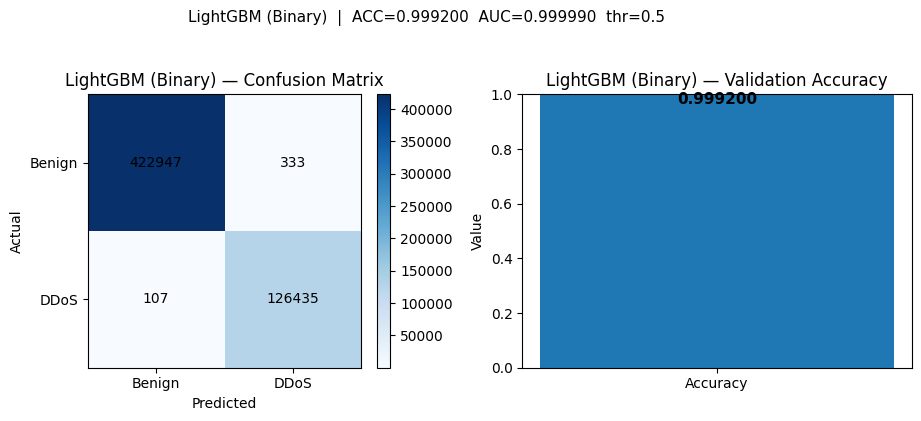


=== LightGBM (Binary) ===
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    423280
        DDoS       1.00      1.00      1.00    126542

    accuracy                           1.00    549822
   macro avg       1.00      1.00      1.00    549822
weighted avg       1.00      1.00      1.00    549822

ROC-AUC: 0.9999899031971388


In [ ]:
# %% LSTM SOTA (Binary) — phiên bản an toàn cho Win11/TF 2.16 (không JIT, MHA nhẹ)
import tensorflow as tf, gc
from tensorflow.keras import layers, models, callbacks # type: ignore
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report

tf.keras.backend.clear_session(); gc.collect()

EPOCHS_SOTA = 20         # 30 -> 20 (vẫn EarlyStopping)
BATCH_SOTA  = 512        # 2048 -> 512 (giảm đột ngột nguy cơ OOM)

def focal_binary_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1.0-eps)
        pt = tf.where(tf.equal(y_true,1), y_pred, 1-y_pred)
        w  = tf.where(tf.equal(y_true,1), alpha, 1-alpha)
        return -tf.reduce_mean(w * tf.pow(1-pt, gamma) * tf.math.log(pt))
    return loss

def find_best_threshold(y_true, y_prob, min_recall=None):
    p, r, thr = precision_recall_curve(y_true, y_prob)
    f1 = 2*p[:-1]*r[:-1]/(p[:-1]+r[:-1] + 1e-9)
    if min_recall is not None:
        mask = r[:-1] >= float(min_recall)
        idx = (np.flatnonzero(mask)[f1[mask].argmax()] if mask.any() else f1.argmax())
    else:
        idx = f1.argmax()
    return float(thr[idx]), float(p[idx]), float(r[idx]), float(f1[idx])

class AttnPool(layers.Layer):
    def __init__(self, **kw): super().__init__(**kw); self.dense = layers.Dense(1)
    def call(self, x):  # (B,T,H)
        w = tf.nn.softmax(self.dense(x), axis=1)
        return tf.reduce_sum(w * x, axis=1)

def se_block(x, r=8, name="se"):
    c = x.shape[-1]
    s = layers.GlobalAveragePooling1D(name=f"{name}_gap")(x)
    s = layers.Dense(int(c//r), activation="relu", name=f"{name}_fc1")(s)
    s = layers.Dense(int(c), activation="sigmoid", name=f"{name}_fc2")(s)
    s = layers.Reshape((1, int(c)))(s)
    return layers.Multiply(name=f"{name}_scale")([x, s])

def build_lstm_sota_safe(input_len):
    inp = layers.Input(shape=(input_len, 1), name="in")
    x = layers.Conv1D(96, 5, padding="same", activation="relu")(inp)
    x = layers.Conv1D(96, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = se_block(x, r=8, name="stem_se")
    x = layers.Dropout(0.15)(x)

    # BiLSTM (bỏ recurrent_dropout để tiết kiệm RAM)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2), name="bilstm1")(x)
    x = layers.Bidirectional(layers.LSTM(64,  return_sequences=True, dropout=0.2), name="bilstm2")(x)

    # Multi-Head Attention nhẹ hơn
    d_model = 96
    x_proj = layers.Dense(d_model)(x)
    x_mha  = layers.MultiHeadAttention(num_heads=4, key_dim=d_model//4, dropout=0.1)(x_proj, x_proj)
    x      = layers.LayerNormalization(epsilon=1e-6)(x_proj + x_mha)

    ff = layers.Dense(d_model*2, activation="gelu")(x)  # 2x thay vì 4x
    ff = layers.Dropout(0.1)(ff)
    ff = layers.Dense(d_model)(ff)
    x  = layers.LayerNormalization(epsilon=1e-6)(x + ff)

    x = AttnPool()(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(inp, out, name="LSTM_SOTA_Safe")

lstm_sota = build_lstm_sota_safe(X_train_dl.shape[1])
lstm_sota.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=focal_binary_loss(2.0, 0.25),
    metrics=[tf.keras.metrics.AUC(name="auc")],
    jit_compile=False   # TẮT JIT để tránh crash
)

cb_sota = [
    callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor="val_auc", mode="max"),
    callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor="val_auc", mode="max"),
    StopOnTinyChange(monitor="val_auc", min_delta=1e-3),
]

lstm_sota.fit(
    X_train_dl, y_train_dl,
    epochs=EPOCHS_SOTA, batch_size=BATCH_SOTA,
    validation_data=(X_test_dl, y_test_dl),
    callbacks=cb_sota, verbose=1
)

yprob_lstm_sota = lstm_sota.predict(X_test_dl, batch_size=BATCH_SOTA, verbose=0).ravel()
best_thr, bp, br, bf1 = find_best_threshold(y_test, yprob_lstm_sota, min_recall=0.85)
print(f"[LSTM SOTA Safe] best_thr={best_thr:.4f} | P={bp:.3f} R={br:.3f} F1={bf1:.3f}")
print(classification_report(y_test, (yprob_lstm_sota >= best_thr).astype(int), target_names=['Benign','DDoS']))

_ = eval_binary(y_test, yprob_lstm_sota, f"LSTM SOTA (Binary, thr@{best_thr:.3f})", threshold=best_thr)
save_model_h5_any(lstm_sota, "LSTM_SOTA_Binary_Phase1", extra={"best_threshold": best_thr})
show_cm_and_valacc("LSTM SOTA (Binary)", y_test, yprob_lstm_sota, threshold=best_thr,
                   savepath=str(DIR_PLOTS / f"LSTM_SOTA_Binary_Phase1-{_stamp()}.png"))



# **Phase 2: Chuẩn bị dữ liệu đa lớp (AttackType)**

In [13]:
# Lấy tất cả mẫu DDoS
df_attack = df_all[df_all['Label']=='DDoS'].copy()
X_attack = df_attack.reindex(columns=feature_candidates, fill_value=0.0).astype(np.float32)
X_attack_s = scaler.transform(X_attack)

# Mã hoá nhãn AttackType
y_attack_txt = df_attack['AttackType'].astype(str).values
le_attack = LabelEncoder()
y_attack = le_attack.fit_transform(y_attack_txt)
num_classes = len(le_attack.classes_)
joblib.dump(le_attack, ROOT_SAVE / "attack_label_encoder_union.pkl")
print("Classes:", list(le_attack.classes_))

# SMOTE multiclass
X_attack_res, y_attack_res = SMOTE(random_state=RANDOM_STATE).fit_resample(X_attack_s, y_attack)

# Train/test split
Xa_tr, Xa_te, ya_tr, ya_te = train_test_split(
    X_attack_res, y_attack_res, test_size=0.2, random_state=RANDOM_STATE, stratify=y_attack_res
)
Xa_tr = Xa_tr.astype(np.float16)
Xa_te = Xa_te.astype(np.float16)
print("Train:", Xa_tr.shape, "Test:", Xa_te.shape)

# Lưu để DL Phase-2 dùng
Xa_tr_dl = Xa_tr.astype(np.float32).reshape(-1, Xa_tr.shape[1], 1)
Xa_te_dl = Xa_te.astype(np.float32).reshape(-1, Xa_te.shape[1], 1)


Classes: ['Brute Force', 'DoS', 'LDAP', 'MSSQL', 'Other', 'PortScan', 'Syn', 'UDP', 'Web Attack']


MemoryError: Unable to allocate 404. MiB for an array with shape (339151, 156) and data type float64

# **Deep Learning SOTA (Hybrid CNN + BiLSTM + Transformer Attention) - Phase 2**

In [ ]:
# %% LSTM SOTA — Phase-2 (Multiclass, SAFE)
import tensorflow as tf, gc
from tensorflow.keras import layers, models, callbacks  # type: ignore
from sklearn.metrics import classification_report, accuracy_score

tf.keras.backend.clear_session(); gc.collect()

EPOCHS_SOTA2 = 20          # 30 -> 20 (EarlyStopping vẫn bật)
BATCH_SOTA2  =1024         # 2048 -> 512 (ổn định RAM)
num_classes  = len(le_attack.classes_)
input_len    = Xa_tr_dl.shape[1]

def se_block(x, r=8, name="se"):
    c = x.shape[-1]
    s = layers.GlobalAveragePooling1D(name=f"{name}_gap")(x)
    s = layers.Dense(int(c//r), activation="relu", name=f"{name}_fc1")(s)
    s = layers.Dense(int(c),    activation="sigmoid", name=f"{name}_fc2")(s)
    s = layers.Reshape((1, int(c)))(s)
    return layers.Multiply(name=f"{name}_scale")([x, s])

class AttnPool(layers.Layer):
    def __init__(self, **kw): super().__init__(**kw); self.dense = layers.Dense(1)
    def call(self, x):
        w = tf.nn.softmax(self.dense(x), axis=1)
        return tf.reduce_sum(w * x, axis=1)

def build_lstm_sota_multiclass_safe(input_len, num_classes):
    inp = layers.Input(shape=(input_len, 1), name="in_mc")
    x = layers.Conv1D(96, 5, padding="same", activation="relu")(inp)
    x = layers.Conv1D(96, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = se_block(x, r=8, name="stem_se")
    x = layers.Dropout(0.15)(x)

    # BiLSTM (không recurrent_dropout để tiết kiệm RAM/ổn định)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2), name="bilstm1")(x)
    x = layers.Bidirectional(layers.LSTM(64,  return_sequences=True,  dropout=0.2), name="bilstm2")(x)

    # MHA nhẹ
    d_model = 96
    x_proj  = layers.Dense(d_model)(x)
    x_mha   = layers.MultiHeadAttention(num_heads=4, key_dim=d_model//4, dropout=0.1)(x_proj, x_proj)
    x       = layers.LayerNormalization(epsilon=1e-6)(x_proj + x_mha)

    ff = layers.Dense(d_model*2, activation="gelu")(x)
    ff = layers.Dropout(0.1)(ff)
    ff = layers.Dense(d_model)(ff)
    x  = layers.LayerNormalization(epsilon=1e-6)(x + ff)

    x = AttnPool()(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out, name="LSTM_SOTA_Multiclass_Safe")

lstm_sota_mc = build_lstm_sota_multiclass_safe(input_len, num_classes)
lstm_sota_mc.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    jit_compile=False     # TẮT JIT để tránh crash trên Win11/CPU
)

cb_mc = [
    callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor="val_accuracy"),
    callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5),
]

lstm_sota_mc.fit(
    Xa_tr_dl, ya_tr,
    epochs=EPOCHS_SOTA2, batch_size=BATCH_SOTA2,
    validation_data=(Xa_te_dl, ya_te),
    callbacks=cb_mc, verbose=1
)

# Predict + đánh giá
y_pred_lstm_sota = tf.argmax(lstm_sota_mc.predict(Xa_te_dl, batch_size=BATCH_SOTA2, verbose=0), axis=1).numpy()
print("\nLSTM SOTA (Multiclass SAFE) — Accuracy:", accuracy_score(ya_te, y_pred_lstm_sota))
print(classification_report(ya_te, y_pred_lstm_sota, target_names=le_attack.classes_))

# Alias cho cell tổng hợp (để không phải sửa cell summary)
y_pred_lstm = y_pred_lstm_sota

# Lưu + plot
save_model_h5_any(lstm_sota_mc, "LSTM_SOTA_Multiclass_Phase2",
                  extra={"classes": list(le_attack.classes_), "feature_order": feature_candidates})
show_cm_and_valacc_multiclass(
    "LSTM SOTA (Multiclass AttackType)",
    ya_te, y_pred_lstm_sota, labels=le_attack.classes_,
    savepath=str(DIR_PLOTS / f"LSTM_SOTA_Multiclass_Phase2-{_stamp()}.png")
)


# **Dọn Ram**

In [ ]:
import gc, sys, types, numpy as np, pandas as pd

KEEP = {
    # artifacts cần giữ
    "feature_candidates", "scaler", "le_attack",
    "xgb_bin","lgb_bin","cat_bin","lstm","gru","cnn","ae",
    "metrics_phase1","metrics_phase2","best_thresholds",
    # config/seed
    "RANDOM_STATE","split_info"
}

SIZE_MB_THRESHOLD = 0  # chỉ dọn biến > 100MB để an toàn

def nbytes(obj):
    try:
        if isinstance(obj, np.ndarray): return obj.nbytes
        if isinstance(obj, pd.DataFrame): return obj.memory_usage(deep=True).sum()
        if isinstance(obj, pd.Series): return obj.memory_usage(deep=True)
        return sys.getsizeof(obj)
    except Exception:
        return 0

deleted = []
for name, val in list(globals().items()):
    if name.startswith("_") or name in KEEP: 
        continue
    if isinstance(val, types.ModuleType) or isinstance(val, types.FunctionType):
        continue
    try:
        mb = nbytes(val) / (1024**2)
        if mb >= SIZE_MB_THRESHOLD:
            del globals()[name]
            deleted.append((name, f"{mb:.1f} MB"))
    except Exception:
        pass

gc.collect()
print("Đã dọn:", deleted[:10], "... tổng:", len(deleted))
